In [3]:
import requests
from bs4 import BeautifulSoup
import os
import zipfile
import glob
import geopandas as gpd
import pandas as pd
import tempfile

In [8]:
# https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp_rd18/TGRSHPRD18_TechDoc.pdf
# https://www2.census.gov/geo/tiger/TIGER2022/ADDRFEAT/
# https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/
def get_data_links() -> list:
    url = 'https://www2.census.gov/geo/tiger/TIGER2022/ADDRFEAT/'

    response = requests.get(url)

    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all <a> tags in the HTML
        a_tags = soup.find_all('a')

        # Extract the href attribute from each <a> tag
        hrefs = [a.get('href') for a in a_tags if a.get('href') is not None]
        hrefs = [item for item in hrefs if 'addrfeat.zip' in item]

        return hrefs
    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")

zipped_links = get_data_links()

In [ ]:
nm_zips = [zip for zip in zipped_links if "tl_2022_35" in zip]
pa_zips = [zip for zip in zipped_links if "tl_2022_42" in zip]

In [ ]:
def bulk_download(links: list, outdir: str):
    url = 'https://www2.census.gov/geo/tiger/TIGER2022/ADDRFEAT/'
    wanted_links = [url + link for link in links]

    if not os.path.exists(outdir):
        os.makedirs(outdir)
        print(f"Directory created: {outdir}")
    else:
        print(f"Directory already exists: {outdir}")

    for link in wanted_links:
        local_zip = outdir + link.split("/")[-1]
        file = link.split("/")[-1]
        if os.path.exists(local_zip):
            print(f"File ({file}) exists")
        else:
            response = requests.get(link)
            if response.status_code == 200:
                # Open the local file in binary write mode
                with open(local_zip, 'wb') as file:
                    # Write the content of the response to the file
                    file.write(response.content)
            else:
                file = outdir + link.split("/")[-1]
                print(f"Failed to download the zip file ({file}). Status code: {response.status_code}")

bulk_download(links=pa_zips, outdir="pazips/")
bulk_download(links=nm_zips, outdir="nmzips/")

In [36]:
def extract_zipped(zippeddir: str, outdir: str):
    assert os.path.exists(zippeddir), 'zippeddir must exist.'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        print(f"Directory created: {outdir}")
    else:
        print(f"Directory already exists: {outdir}")

    files = glob.glob(f'{zippeddir}/*.zip')
    
    for file in files:
        with zipfile.ZipFile(file, 'r') as zip:
            zip.extractall(outdir)

extract_zipped(zippeddir="nmzips", outdir='nmaddrfeat')
extract_zipped(zippeddir="pazips", outdir='paaddrfeat')

Directory already exists: nmaddrfeat
Directory created: paaddrfeat


In [4]:
def read_shapefiles(dir: str) -> gpd.geodataframe.GeoDataFrame:
    files = glob.glob(f'{dir}/*.shp')
    gpds = [gpd.read_file(file) for file in files]
    out = pd.concat(gpds)
    return out

nm = read_shapefiles("nmaddrfeat")
# pa = read_shapefiles("paaddrfeat")

<Axes: >

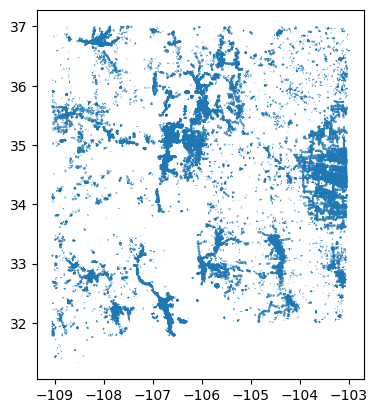

In [5]:
nm.plot()

In [6]:
nm[1:100].explore()

In [9]:
def get_state_block_group(statenid: str, outdir: str) -> gpd.geodataframe.GeoDataFrame:
    url = f"https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_{statenid}_bg.zip"
    res = requests.get(url)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        print(f"Directory created: {outdir}")
    else:
        print(f"Directory already exists: {outdir}")
    tempdir = tempfile.gettempdir()
    if res.status_code == 200:
        local_zip = url.split('/')[-1]
        with open(tempdir + '/' + local_zip, 'wb') as file:
                # Write the content of the response to the file
                file.write(res.content)
        with zipfile.ZipFile(tempdir + '/' + local_zip, 'r') as zip:
            zip.extractall(outdir)
            zip.close()

        print('Download and unzip complete!')
    else:
        print(f"Failed to download the zip file. Status code: {response.status_code}")

get_state_block_group(statenid="35", outdir="blocks/nm")

Directory created: blocks/nm
Download and unzip complete!


<Axes: >

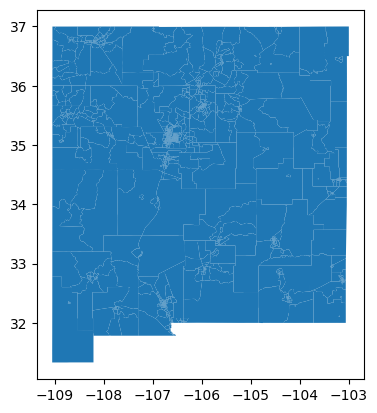

In [12]:
nm_blocks = gpd.read_file('blocks/nm/tl_2022_35_bg.shp')
nm_blocks.plot()

In [14]:
nm_intersection = gpd.sjoin(nm, nm_blocks, how = "left", predicate="intersects")
nm_intersection.head()

,TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,...,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,206770994,215061738,264485458,40020503625998,NaN,1106072566432,Sequoia Rd NW,4900,5012,NaN,...,004729,2,350010047292,Block Group 2,G5030,S,1469536,125880,+35.1140434,-106.6970752
0,206770994,215061738,264485458,40020503625998,NaN,1106072566432,Sequoia Rd NW,4900,5012,NaN,...,004729,1,350010047291,Block Group 1,G5030,S,3156634,314433,+35.1357196,-106.6933468
1,206767829,215061738,215061738,400493071712,400493104056,110497121449,Sequoia Ct NW,3501,5099,3500,...,004729,2,350010047292,Block Group 2,G5030,S,1469536,125880,+35.1140434,-106.6970752
1,206767829,215061738,215061738,400493071712,400493104056,110497121449,Sequoia Ct NW,3501,5099,3500,...,004729,1,350010047291,Block Group 1,G5030,S,3156634,314433,+35.1357196,-106.6933468
2,206704471,215061738,264485458,40020503626587,NaN,1106072566432,Sequoia Rd NW,3500,3598,NaN,...,004729,2,350010047292,Block Group 2,G5030,S,1469536,125880,+35.1140434,-106.6970752


In [19]:
nm_intersection.drop(columns="geometry").to_csv("nm_addresses.csv")